# Reconstruction of DOSY NMR signals - Part I

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import random

## 1) Generation of synthetic data


$\underline{\textbf{Q1.}}$ Let's read the signal data from the file "signal.dat" 

In [5]:
N = 200
signal = np.zeros(N)

filepath = 'signal.txt'  
with open(filepath) as fp:  
    line = fp.readline()
    cnt = 1
    while line:
        signal[cnt-1] = np.float64(line)
        line = fp.readline()
        cnt += 1
    
signal

array([2.0440461e-15, 9.5346375e-15, 4.2731280e-14, 1.8399916e-13,
       7.6122670e-13, 3.0258013e-12, 1.1555667e-11, 4.2401169e-11,
       1.4948199e-10, 5.0632357e-10, 1.6477664e-09, 5.1521838e-09,
       1.5478015e-08, 4.4675295e-08, 1.2389329e-07, 3.3010826e-07,
       8.4507101e-07, 2.0785393e-06, 4.9119223e-06, 1.1152519e-05,
       2.4328910e-05, 5.0991828e-05, 1.0268493e-04, 1.9867402e-04,
       3.6932070e-04, 6.5962097e-04, 1.1319141e-03, 1.8662109e-03,
       2.9562161e-03, 4.4992472e-03, 6.5791799e-03, 9.2434029e-03,
       1.2477289e-02, 1.6182171e-02, 2.0164227e-02, 2.4140963e-02,
       2.7768717e-02, 3.0689178e-02, 3.2586891e-02, 3.3245190e-02,
       3.2586892e-02, 3.0689180e-02, 2.7768719e-02, 2.4140966e-02,
       2.0164233e-02, 1.6182182e-02, 1.2477307e-02, 9.2434342e-03,
       6.5792322e-03, 4.4993339e-03, 2.9563583e-03, 1.8664419e-03,
       1.1322857e-03, 6.6021251e-04, 3.7025309e-04, 2.0012899e-04,
       1.0493282e-04, 5.4430173e-05, 2.9535840e-05, 1.8959282e

$\underline{\textbf{Q2.}}$  We create first T using an exponential sampling strategy:

In [6]:
T_min = 1 
T_max = 1000
T = np.array([T_min*np.exp(-n*(np.log(T_min/T_max))/(N-1)) for n in range(N)],dtype=np.float64)
T

array([   1.        ,    1.03532184,    1.07189132,    1.1097525 ,
          1.148951  ,    1.18953407,    1.2315506 ,    1.27505124,
          1.3200884 ,    1.36671636,    1.4149913 ,    1.4649714 ,
          1.51671689,    1.57029012,    1.62575567,    1.68318035,
          1.74263339,    1.80418641,    1.8679136 ,    1.93389175,
          2.00220037,    2.07292178,    2.1461412 ,    2.22194686,
          2.30043012,    2.38168555,    2.46581108,    2.55290807,
          2.64308149,    2.73644   ,    2.8330961 ,    2.93316628,
          3.03677112,    3.14403547,    3.2550886 ,    3.37006433,
          3.48910121,    3.6123427 ,    3.7399373 ,    3.87203878,
          4.00880633,    4.15040476,    4.2970047 ,    4.44878283,
          4.60592204,    4.7686117 ,    4.93704785,    5.11143348,
          5.29197874,    5.47890118,    5.67242607,    5.87278661,
          6.08022426,    6.29498899,    6.5173396 ,    6.74754405,
          6.98587975,    7.2326339 ,    7.48810386,    7.75259

$\underline{\textbf{Q3.}}$ Display the original signal $\bar{x}$ as a function of T

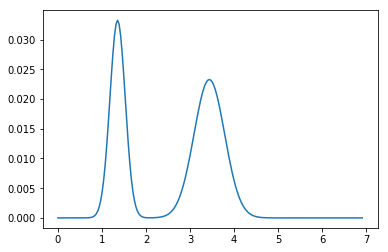

In [7]:
plt.plot(np.log(T),signal)

$\underline{\textbf{Q4.}}$  Create t using a regular sampling strategy 

In [8]:
M = 50 
t_min = 0
t_max = 1.5
t = np.array([t_min + ((m-1)/(M-1))*(t_max - t_min) for m in range(1,M+1)],dtype=np.float64)
t

array([0.        , 0.03061224, 0.06122449, 0.09183673, 0.12244898,
       0.15306122, 0.18367347, 0.21428571, 0.24489796, 0.2755102 ,
       0.30612245, 0.33673469, 0.36734694, 0.39795918, 0.42857143,
       0.45918367, 0.48979592, 0.52040816, 0.55102041, 0.58163265,
       0.6122449 , 0.64285714, 0.67346939, 0.70408163, 0.73469388,
       0.76530612, 0.79591837, 0.82653061, 0.85714286, 0.8877551 ,
       0.91836735, 0.94897959, 0.97959184, 1.01020408, 1.04081633,
       1.07142857, 1.10204082, 1.13265306, 1.16326531, 1.19387755,
       1.2244898 , 1.25510204, 1.28571429, 1.31632653, 1.34693878,
       1.37755102, 1.40816327, 1.43877551, 1.46938776, 1.5       ])

 $\underline{\textbf{Q4.}}$ Construct matrix K using (3)

In [9]:
##### I should change this (no loop) ###########

K = np.zeros((M,N))

for n in range(N):
    for m in range(M):
        K[m,n] = np.exp(- t[m]*T[n])

$\underline{\textbf{Q5.}}$ Simulate the noisy data according to model (2), by taking $w \sim \mathcal{N} (0, \sigma^2 I_{M})$ with $\sigma = 0.01z^{(1)}$ , where $z = K\bar{x}$

In [10]:
x = signal
xmin = min(x)
xmax = max(x)
z = np.dot(K,x)
sigma = 0.01*z[0]
mean = np.zeros(M)
cov  = (sigma**2)*np.eye(M)

w = np.random.multivariate_normal(mean, cov)
y = z + w

$\underline{\textbf{Q6.}}$ Display the resulting noisy data y as a function of t

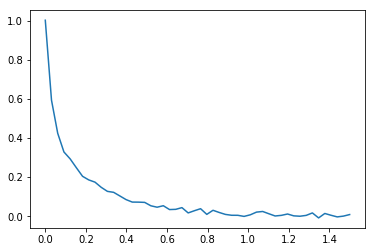

In [11]:
plt.plot(t,y)

## 2) Comparison of regularization strategies

###  Smoothness prior

Defintion of D

In [12]:
D = np.eye(N)

for n in range(N-1):
    D[n+1,n] = -1

D[0,N-1] = -1

$inf_{x\in\mathbb{R}^n}\ \frac{1}{2}\ \lVert Kx - y \rVert^2_2 + \frac{\beta}{2}\ \lVert Dx \rVert^2_2 = inf_{x\in\mathbb{R}^n}\ J(x)$

J is coercive so a minimum exists. J is striclty convex because $\nabla^2 J = K^\top K + \beta\ D^\top D$ is symetric positive. Therefore the minimum is unique.

$\underline{\textbf{Q3.}}$ Solving the optimization problem

In [13]:
beta = 1
x_hat = np.dot(np.linalg.inv(np.dot(K.T,K) + beta*np.dot(D.T,D)),np.dot(K.T,y))

In [14]:
def normalized_MSE(x,y):
    return( (np.linalg.norm(x-y)/np.linalg.norm(y))**2)

0.34141894720625043


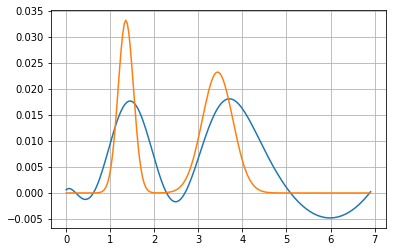

In [15]:
print(normalized_MSE(x_hat,x))
plt.plot(np.log(T),x_hat)
plt.plot(np.log(T),x)
plt.grid()

$\underline{\textbf{Q4.}}$ Tunning $\beta$ with a grid search 

MSE : 1.5325397724193488, beta : 0.009999999999999995


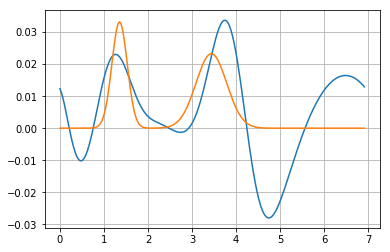

MSE : 0.21877164380163533, beta : 0.09999999999999998


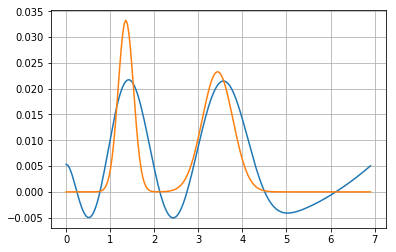

MSE : 0.34141894720625043, beta : 1.0


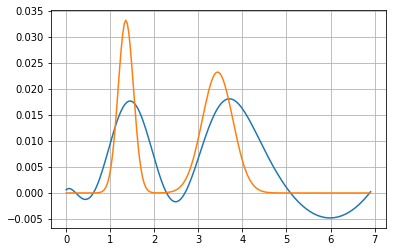

MSE : 0.43137284226180017, beta : 10.000000000000002


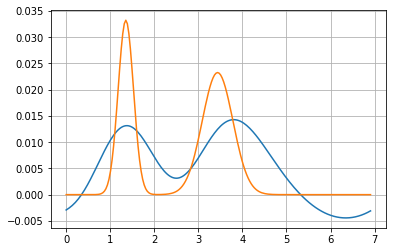

MSE : 0.47911304553834577, beta : 100.00000000000004


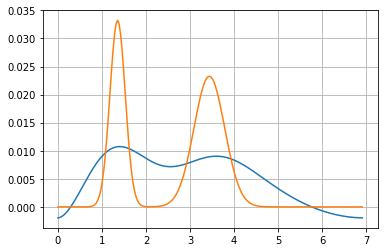

In [16]:
beta_grid = np.exp(np.log(10)*np.linspace(-2,2,5))
errors = np.zeros(beta_grid.shape[0])

for i in range(beta_grid.shape[0]):
    beta = beta_grid[i]
    x_hat = np.dot(np.linalg.inv(np.dot(K.T,K) + beta*np.dot(D.T,D)),np.dot(K.T,y))
    errors[i] = normalized_MSE(x_hat,x)
    print("MSE : {}, beta : {}".format(normalized_MSE(x_hat,x),beta))
    plt.plot(np.log(T),x_hat)
    plt.plot(np.log(T),x)
    plt.grid()
    plt.show()

### Smoothness prior + constraints 


$inf_{x\in\mathbb{R}^N}\ \frac{1}{2}\ \lVert Kx - y \rVert^2_2 + \frac{\beta}{2}\ \lVert Dx \rVert^2_2 + \iota_{[x_{min},x_{max}]^N}(x)= inf_{x\in[x_{min},x_{max}]^N}\ J(x)$

$[x_{min},x_{max}]^N$ is compact and L is continuous so L admits a minimum on $[x_{min},x_{max}]^N$. L is striclty convex because $\nabla^2 J = K^\top K + \beta\ D^\top D$ is symetric positive. Thus, the minimum is unique.

MSE : 0.17056871882776378, beta : 0.0009999999999999994



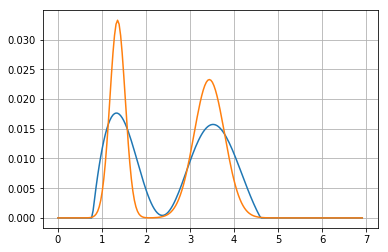

MSE : 0.17081125640416925, beta : 0.009999999999999995



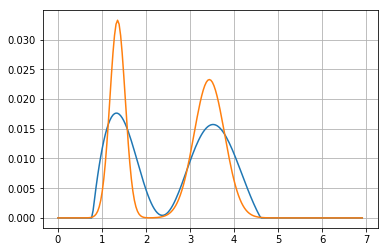

MSE : 0.1729633262596218, beta : 0.09999999999999998



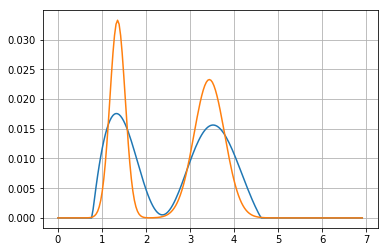

MSE : 0.18774184629314045, beta : 1.0



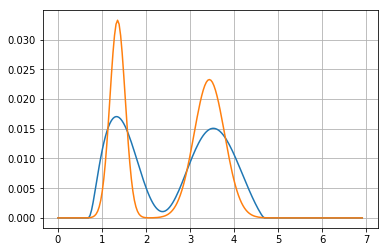

MSE : 0.28185328845100993, beta : 10.000000000000002



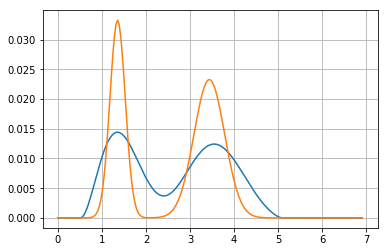

In [190]:
beta_grid = np.exp(np.log(10)*np.linspace(-3,1,5))

def proximal_gradient_smooth_cons(lamb,K,y,T,xmin,xmax,display = False):
    tol = 1e-8
    max_iter = 1000
    nb_iter = 0
    m = K.shape[0]
    n = K.shape[1]
    u = np.zeros((n,1))
    w,v = np.linalg.eig(np.dot(K.T,K) + lamb * np.dot(D.T,D))
    L = max(w)
    epsilon = 1/L
    norm2 = np.linalg.norm(np.dot(K,u) - y.reshape(m,1))
    normD = np.linalg.norm(np.dot(D,u))
    obj = 0.5 * norm2 **2 + 0.5 * lamb * normD ** 2 + ind(u,xmin,xmax)
    last_obj = 0
    if display:
        print("Objectif : {}, ||Ku-y||^2 : {}, ||Du||^2 : {}, ind : {}".format(obj,norm2**2,normD**2,ind(u,xmin,xmax)))
    
    while abs(obj - last_obj) > tol:
        w = u - epsilon * (np.dot(K.T,np.dot(K,u) - y.reshape(m,1)) + lamb * np.dot(D.T,np.dot(D,u)))
        last_obj = obj
        u = prox_cons(w,xmin,xmax) 
        norm2 = np.linalg.norm(np.dot(K,u) - y.reshape(m,1))
        normD = np.linalg.norm(np.dot(D,u))
        obj = 0.5 * norm2 **2 + 0.5*lamb * normD ** 2 + ind(u,xmin,xmax)
        if display:
            print("Objectif : {}, ||Ku-y||^2 : {}, ||Du||^2 : {}, ind : {}".format(obj,norm2**2,normD**2,ind(u,xmin,xmax)))
        nb_iter += 1
        
    return u
        
def prox_cons(w,xmin,xmax):
    m = w.shape[0]
    out = np.zeros((m,1))
    for index in range(m):
        value = w[index,0]
        if value >  xmax:
            out[index,0] = xmax
        elif value <  xmin:
            out[index,0] = xmin
        elif value >= xmin and value <= xmax:
            out[index,0] = value
    return out

def ind(x,xmin,xmax):
    n = x.shape[0]
    for i in range(n):
        if x[i] > xmax or x[i] < xmin:
            return 1e30
    return 0

for i in range(beta_grid.shape[0]):
    beta = beta_grid[i]
    x_hat = proximal_gradient_smooth_cons(beta,K,y,T,xmin,xmax) #,True
    print("MSE : {}, beta : {}\n".format(normalized_MSE(x_hat,x.reshape(200,1)),beta))
    plt.plot(np.log(T),x_hat)
    plt.plot(np.log(T),x)
    plt.grid()
    plt.show()

### Sparsity 


$inf_{x\in\mathbb{R}^n}\ \frac{1}{2}\ \lVert Kx - y \rVert^2_2 + \beta\ \lVert x \rVert_1 = inf_{x\in\mathbb{R}^n}\ F(x)$

F is coercive because ...
F is striclty convex because ...
Thus the minimum is unique.

MSE : 0.22950008299493024, beta : 9.999999999999991e-05


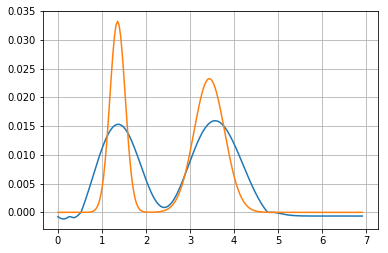

MSE : 0.17786621955783347, beta : 0.0009999999999999994


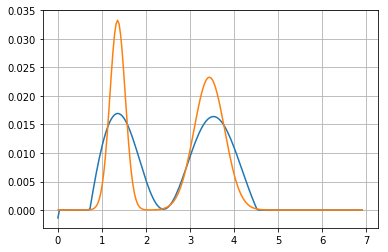

MSE : 0.1656063030859874, beta : 0.009999999999999995


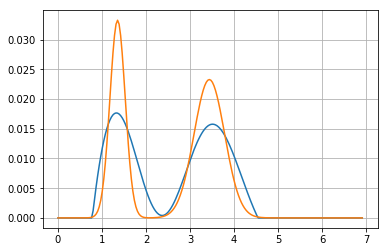

MSE : 0.1518215077411453, beta : 0.09999999999999998


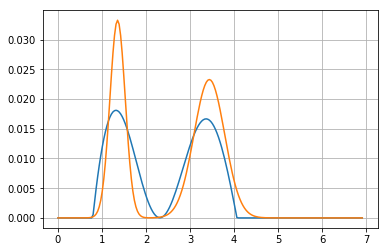

MSE : 1.0694273873275189, beta : 1.0


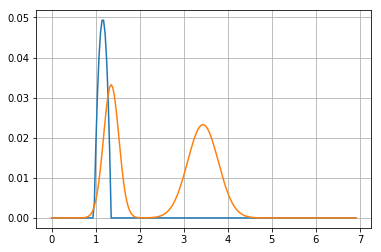

In [188]:
beta_grid = np.exp(np.log(10)*np.linspace(-4,0,5))

def proximal_gradient_norme1(lamb,K,y,T,display = False):
    tol = 1e-8
    nb_iter = 0
    m = K.shape[0]
    n = K.shape[1]
    w,v = np.linalg.eig(np.dot(K.T,K))
    epsilon = 1/np.real(np.max(w))
    u = np.zeros((n,1))
    norm2 = np.linalg.norm(np.dot(K,u) - y.reshape(m,1))
    norm1 = np.linalg.norm(u,1)
    obj = 0.5*norm2**2 + lamb * norm1
    last_obj = 0
    if display:
        print("Objectif : {}, ||Ku-y||^2 : {}, ||u|| : {}".format(obj,norm2**2,norm1))
    
    while abs(obj - last_obj) > tol:
        w = u - epsilon * np.dot(K.T,(np.dot(K,u) - y.reshape(m,1)))
        last_obj = obj
        u = prox_norme1(w,lamb,epsilon) 
        norm2 = np.linalg.norm(np.dot(K,u) - y.reshape(m,1))
        norm1 = np.linalg.norm(u,1)
        obj = 0.5*norm2**2 + lamb * norm1
        if display:
            print("Objectif : {}, ||Ku-y||^2 : {}, ||u|| : {}".format(obj,norm2**2,norm1))
        nb_iter += 1
    
    return u
        
def prox_norme1(w,lamb,epsilon):
    n = w.shape[0]
    out = np.zeros((n,1))
    for index in range(n):
        value = w[index,0]
        if value >  epsilon * lamb :
            out[index,0] = value - epsilon * lamb
        elif value <  -epsilon * lamb :
            out[index,0] = value + epsilon * lamb 
        elif value >=  -epsilon * lamb and value <= epsilon * lamb:
            out[index,0] = 0
    return out

for i in range(beta_grid.shape[0]):
    beta = beta_grid[i]
    x_hat = proximal_gradient_norme1(beta,K,y,T)
    print("MSE : {}, beta : {}".format(normalized_MSE(x_hat,x.reshape(200,1)),beta))
    plt.plot(np.log(T),x_hat)
    plt.plot(np.log(T),x)
    plt.grid()
    plt.show()

In [167]:
def W_exp(u):
    
    m = u.shape[0]
    output = np.zeros((m,1))
    
    for index in range(m):
        val = u[index,0]
        
        if val >= 100:
            output[index,0] = val - np.log(val)
    
        if val < 100 and val > - 20 :
            w = 1
            v = 0
            while abs(w - v)/abs(w) > 1e-6:
                v = w
                e = np.exp(w)
                f = w*e - np.exp(val)
                w = w - f/((e*(w+1) - (w+2)*f/(2*w+2)))
            output[index,0] = w
            
        if val <=-20:
            output[index,0] = 0        
        
    return output

MSE : 0.17091210250815972, beta : 9.999999999999987e-07



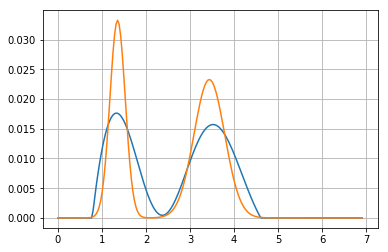

MSE : 0.17269315022677936, beta : 9.99999999999998e-06



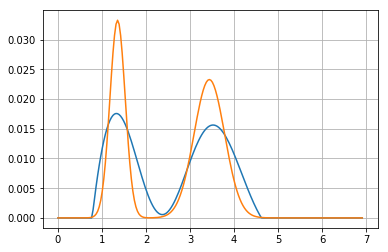

MSE : 0.20879600825192943, beta : 9.999999999999991e-05



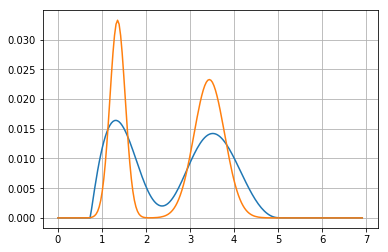

MSE : 0.3124122777377437, beta : 0.0009999999999999994



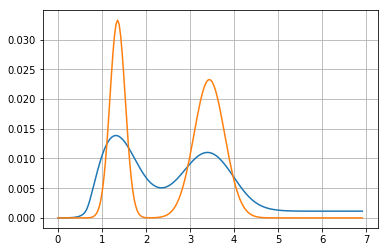

MSE : 0.5694638936249157, beta : 0.009999999999999995



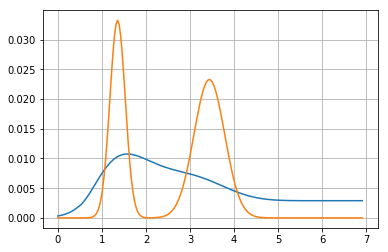

MSE : 0.7324037943853091, beta : 0.09999999999999998



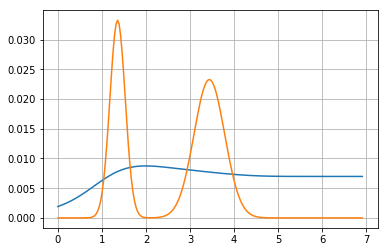

In [184]:
beta_grid = np.exp(np.log(10)*np.linspace(-6,0,5))

def proximal_gradient_entr(lamb,K,y,T,xmin,xmax,display = False):
    tol = 1e-8
    nb_iter = 0
    m = K.shape[0]
    n = K.shape[1]
    u = np.zeros((n,1))
    w,v = np.linalg.eig(np.dot(K.T,K))
    epsilon = 1/np.real(np.max(w))
    norm2 = np.linalg.norm(np.dot(K,u) - y.reshape(m,1))
    entropy = ent(u)
    obj = 0.5 * norm2 **2 + lamb * entropy
    last_obj = 0
    if display:
        print("Objectif : {}, ||Ku-y||^2 : {}, entropy : {}".format(obj,norm2**2,entropy))
    
    while abs(obj - last_obj) > tol :
        w = u - epsilon * np.dot(K.T,np.dot(K,u) - y.reshape(m,1)) 
        last_obj = obj
        u = prox_entr(w/(lamb * epsilon) - (1+np.log(lamb*epsilon))*np.ones(w.shape),lamb,epsilon)  
        #print(u)
        norm2 = np.linalg.norm(np.dot(K,u) - y.reshape(m,1))
        entropy = ent(u)
        obj = 0.5 * norm2 **2 + lamb * entropy
        if display:
            print("Objectif : {}, ||Ku-y||^2 : {}, entropy : {}".format(obj,norm2**2,entropy))
        nb_iter += 1
        
    return u
        
def prox_entr(w,lamb,epsilon): 
    #print(w)    
    return lamb*epsilon*W_exp(w)

def ent(x):
    tol = 1e-5
    n = x.shape[0]
    out = np.zeros((x.shape[0],1))
    for i in range(n):
        value = x[i]
        if value > tol:
            out[i] = value*np.log(value)
        else:
            out[i] = 0
    return sum(out)[0]
        

for i in range(beta_grid.shape[0]):
    beta = beta_grid[i]
    x_hat = proximal_gradient_entr(beta,K,y,T,xmin,xmax) #,True
    print("MSE : {}, beta : {}\n".format(normalized_MSE(x_hat,x.reshape(200,1)),beta))
    plt.plot(np.log(T),x_hat)
    plt.plot(np.log(T),x)
    plt.grid()
    plt.show()